Random Forest algorithm for Machine Failure estimation

In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv('Data/workdata.csv')
df = df.iloc[:, 2:-5]  # Disregard the first two and the last five columns which are noise
#df = df.iloc[:,6]
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,L,298.9,309.1,2861,4.6,143,1
1,L,298.9,309.0,1410,65.7,191,1
2,L,298.8,308.9,1455,41.3,208,1
3,L,298.4,308.2,1282,60.7,216,1
4,L,298.3,308.1,1412,52.3,218,1


In [18]:
df['Machine failure'].value_counts()

Machine failure
0    1200
1     339
Name: count, dtype: int64

In [19]:
from sklearn.model_selection import train_test_split

x = df.drop(['Type','Machine failure'], axis=1) # Disregard the machine failure column
y = df['Machine failure']  # The target variable

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

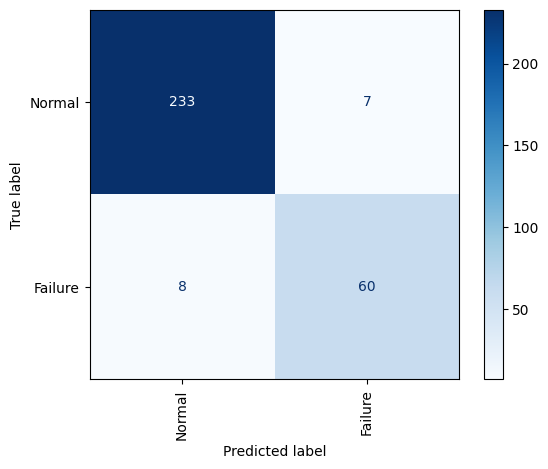

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay as cmd




rf_model = RandomForestClassifier(n_estimators=100, max_features=None, random_state=42)
rf_model.fit(X_train, y_train)



labels = ['Normal', 'Failure']
cmd.from_estimator(rf_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

In [21]:
y_pred = rf_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9512987012987013
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       240
           1       0.90      0.88      0.89        68

    accuracy                           0.95       308
   macro avg       0.93      0.93      0.93       308
weighted avg       0.95      0.95      0.95       308



In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [75, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [None, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', None]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='recall')

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

c:\Users\bayka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\bayka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\bayka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\bayka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\bas

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


After the grid search the "Ideal parameters" are input into the classifier  

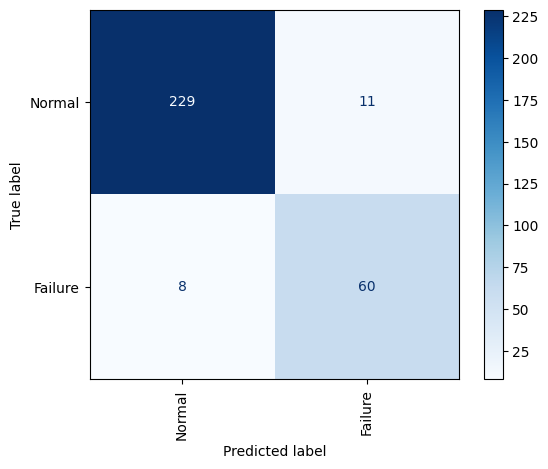

In [37]:
rf_model = RandomForestClassifier(max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, class_weight={0: 1, 1: 4}, random_state=42)
rf_model.fit(X_train, y_train)



labels = ['Normal', 'Failure']
cmd.from_estimator(rf_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

Accuracy: 0.8928571428571429
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       240
           1       0.68      0.97      0.80        68

    accuracy                           0.89       308
   macro avg       0.84      0.92      0.86       308
weighted avg       0.92      0.89      0.90       308



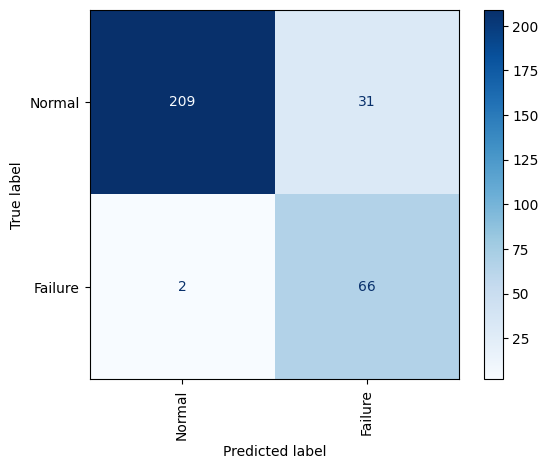

In [24]:
#rf_model = RandomForestClassifier(n_estimators=100, max_features=None, random_state=42)
#rf_model.fit(X_train, y_train)

proba = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.1
y_pred = (proba >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

cmd.from_predictions(y_test, y_pred, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

As we can see we achieve a decent result with random forest, especially when the custom threshold is placed on the system achieving 0.96 recall on machine failure

Lets try with Logistic regression and see if that performs better

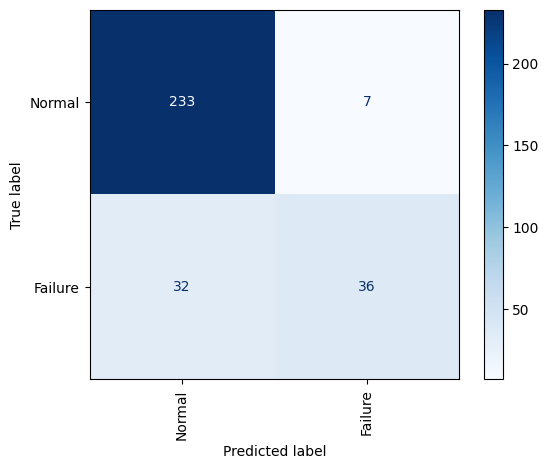

In [25]:
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

cmd.from_estimator(lr_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

In [58]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced',  {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0: 1, 1: 8}, {0: 1, 1: 10}],
    'max_iter': [100, 200, 300]
}

# Use recall as the scoring metric
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    scoring='recall',
    cv=5
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

Best Parameters: {'C': 0.01, 'class_weight': {0: 1, 1: 10}, 'max_iter': 100}
Best Recall Score: 0.9779124579124578


Accuracy: 0.5811688311688312
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.47      0.63       240
           1       0.34      0.99      0.51        68

    accuracy                           0.58       308
   macro avg       0.67      0.73      0.57       308
weighted avg       0.85      0.58      0.61       308



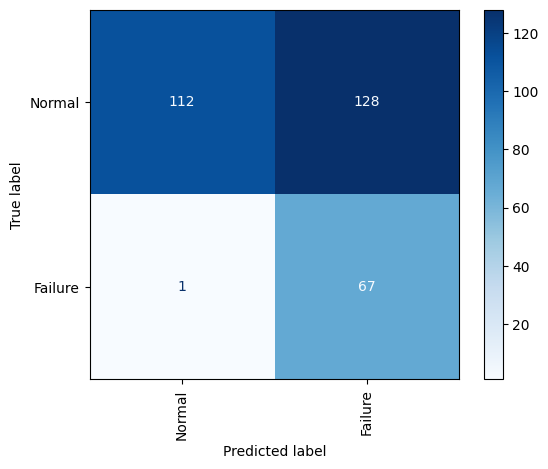

In [62]:
lr_model = LogisticRegression(random_state=42, C=0.01, class_weight={0: 1, 1: 10}, max_iter=100)
lr_model.fit(X_train, y_train)

cmd.from_estimator(lr_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')


# Evaluate the model
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7597402597402597
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82       240
           1       0.48      0.94      0.63        68

    accuracy                           0.76       308
   macro avg       0.73      0.82      0.73       308
weighted avg       0.87      0.76      0.78       308



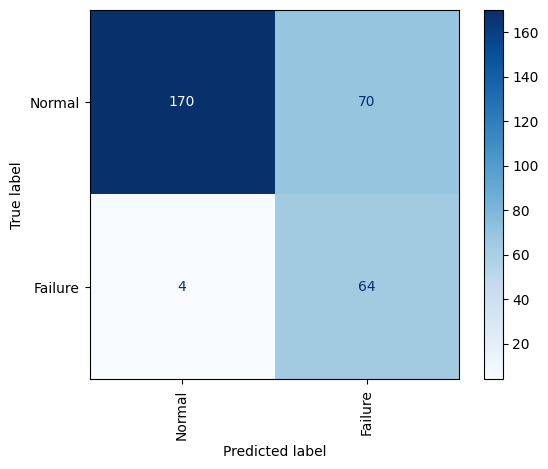

In [28]:
lr_model = LogisticRegression(random_state=42, C=0.1)
lr_model.fit(X_train, y_train)

proba = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
threshold = 0.1
predictions = (proba >= threshold).astype(int)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, predictions))

cmd.from_predictions(y_test, predictions, display_labels=labels, cmap='Blues', xticks_rotation='vertical')



Lastly we look at the effect of scaling the features beforehand, this also allows us to see the influence of the features

Accuracy: 0.9025974025974026
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       240
           1       0.70      0.97      0.81        68

    accuracy                           0.90       308
   macro avg       0.85      0.93      0.87       308
weighted avg       0.93      0.90      0.91       308



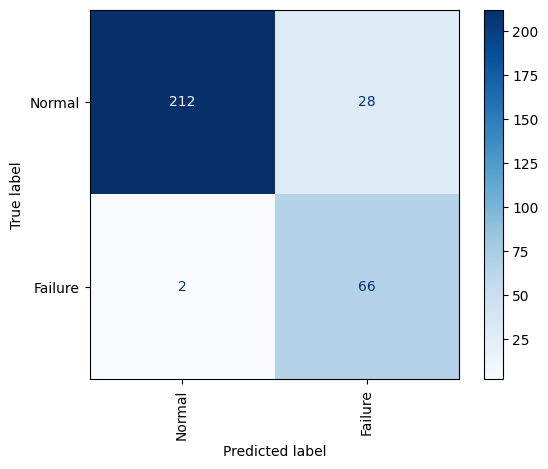

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, max_features=None, random_state=42)
rf_model.fit(X_train, y_train)




proba = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.1
y_pred = (proba >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

cmd.from_predictions(y_test, y_pred, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

Accuracy: 0.6785714285714286
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.74       240
           1       0.40      0.97      0.57        68

    accuracy                           0.68       308
   macro avg       0.70      0.78      0.66       308
weighted avg       0.86      0.68      0.71       308



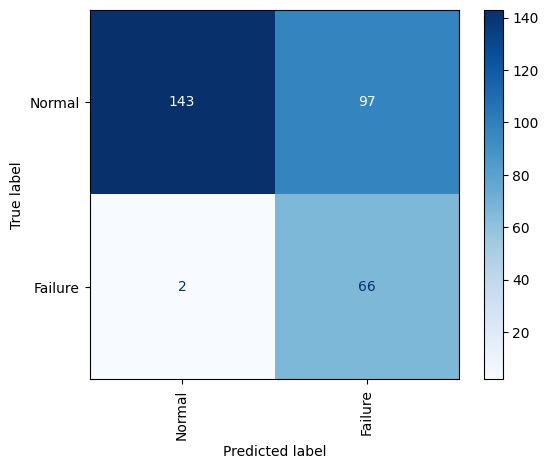

In [55]:
lr_model = LogisticRegression(random_state=42, C=0.1)
lr_model.fit(X_train, y_train)

proba = lr_model.predict_proba(X_test)[:, 1]
threshold = 0.107
y_pred = (proba >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

cmd.from_predictions(y_test, y_pred, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

Then looking into what features influence the result the most

In [31]:
# Get feature importances
feature_importances = rf_model.feature_importances_
feature_names = x.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the importance
print(importance_df)

                   Feature  Importance
3              Torque [Nm]    0.329882
2   Rotational speed [rpm]    0.292759
4          Tool wear [min]    0.187738
0      Air temperature [K]    0.119987
1  Process temperature [K]    0.069634


Now for LR

In [32]:
# Get coefficients
coefficients = lr_model.coef_[0]  # Coefficients for the positive class
feature_names = x.columns

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

# Sort by absolute value of coefficients
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

# Display the importance
print(feature_importance)

                   Feature  Coefficient  Absolute_Coefficient
3              Torque [Nm]     2.395356              2.395356
2   Rotational speed [rpm]     1.801489              1.801489
0      Air temperature [K]     1.448529              1.448529
1  Process temperature [K]    -0.950475              0.950475
4          Tool wear [min]     0.873322              0.873322
